In [1]:
from pathlib import Path
import sys
sys.path.append('../src/tools/pyfferaph')

In [2]:
import numpy as np
import seaborn as sns
import pyfferaph as pf
import filter_pyff as pyff 
import MDAnalysis as mda
import pandas as pd
import multiprocessing

# Pyfferaph:

To remember, all the input files and selection are specifies using dictionaries. We have then to prepare the initial settings:

**data_dict** contains the trajctory and topology files 

**analysis_dict** contains the selection of the N residues for which the interaction networks (N x N matrices) will be computed, the stride used to read the trajectory file and the starting and ending frame to be analysed 

**salt_dict** contains the selection for the salt bridge interactions, the default distance is set to 4.5 A and the output name for the interaction file 

**hc_dict** contains the selection for the hydrophbic interactions, the default distance is set to 5 A and the output name for the interaction file 

**hb_dict** contains the selection for the hydrogen bonds, the default distance is set to 3.5 A, the Donor-H-Acceptor angle to 120° and the output name for the interaction file. Since this function can run on more than one core the number of cores is specified here, 0 means that pyfferaph will make use of all the available cores

In [3]:
# defining paths: 
setup_path1 = Path('../data/03_prod_out/')
setup_path2 = Path('../data/00_starting_material/')

# defining inputs:
XTC = setup_path1 / 'step7_1_noPBC.xtc'
TOP = setup_path1 / 'step7_1.tpr'
PDB = setup_path2 / 'LukFPV_1pvl.pdb' 

In [4]:
# Input: insert the principal files in this dictionary
data_dict = dict(pdb=str(PDB),
                 traj=str(XTC),
                 top=str(TOP)
                )

In [5]:
# Analysis dict:

# Common data: the argument `system` is required to create the proper
# matrix. Use "protein or resname DGPS" if you want include DGPS lipids
analysis_dict = dict(system="protein",
                     start = 0,   # starting frame
                     stop = None, # top frame automatically (if 'None' is inserted)
                     stride = 50   # number of frame to decorrelate, you should insert 
                                  # the simualtion time divided by
                                  # the decorrelation time, so that you can obtain the proper number 
                                  # of frames decorrelated --> we don't have an auto-correlation time, retain 1
                     )

# Salt bridge selection. To include lipids, modify `sel_basic` and `sel_acidic` accordingly.
sb_dict = dict(sb_file="../report/files/pyff_sb.dat",
               sel_basic="(resname LYS and name CE NZ HZ*) or (resname ARG and name CD NE CZ NH1 NH2 HH11 HH12 HH21 HH22)",
               sel_acidic="(resname ASP and name CG OD1 OD2) or (resname GLU and name CD OE1 OE2)",
               sb_dist=4.5,
               # Define if there are charged cter, nter and protonated his, ... --> very important, look into
               # the topology file, and see if basically the sum of charges gives 0 or not in the case of both
               # N, C terms.
               cter_sel="(resid 301 and name C OT1 OT2)",
               nter_sel="(resid 301 and name N HT1 HT2 HT3)",
               histidine_sel=""
               )

# The hydrophobic contacts: here you can just modify the cutoff, but leave everything as it is. 
hc_dict = dict(hc_file="../report/files/pyff_hc.dat",
               hydrophobic_sel="resname ALA ILE VAL LEU PHE MET TRP PRO", 
               backbone_sel="name N H HN CA HA C O OT1 OT2 HT2",
               hc_cutoff=5.
               )

# Hydrogen bond selections. To include other molecule, modify acceptor and donor selections accordingly 
# NB: ncores defines the number of cores to run the hb analysis in parallel, ncores=0 means all the available cores.
hb_dict = dict(hb_file="../report/files/pyff_hb.dat",
               tmp_csv="../report/files/pyff_tmp_file",
               acceptors="protein and name OH OG OD1 OD2 OG1 O ND1 NE2 OE2 OW SG OE1 OH2 SD",
               donors="protein and name OH OG NE2 OG1 NE N ND1 NZ NH1 NH2 OW ND2 SG OH2 NE1",
               d_a_dist=3.5,
               angle=120,
               update_sel=False,
               ncores=6 # maybe this is too low!
               )

### Salt bridges
Computing the salt bridge interaction network and plotting the resulting matrix.

In [6]:
# first build the initial object as input, by passing to the pf.SaltBridges function all the inputs of the 
# dictionaries. 
sb = pf.SaltBridges(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   sb_dict=sb_dict)

sb_network = sb.run() # build the network

sns.heatmap(sb_network, square=True) # print the heatmap for initial visualization

/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/lib/distances.py:715: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in

<AxesSubplot:>

In [8]:
# now, do the persistence analysis determining some certain values for the minimum persistence threshold:
sb_matrix = np.loadtxt("../report/files/pyff_sb.dat") # name the matrix
pyff.cluster_plotter(sb_matrix, '../report/imgs/pyff_sb_cluster.pdf', stride=0.1) # plot it and save it

### Hydrophobic contacts
Computing the hydrogen bonds interaction network and plotting the resulting matrix.

/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)


<AxesSubplot:>

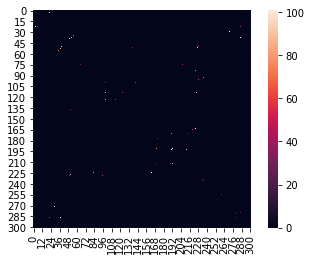

In [9]:
# same thing for Salt Bridges:
hc = pf.HydrophobicInteractions(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   hc_dict=hc_dict)

hc_network = hc.run()

sns.heatmap(hc_network, square=True)

As done previously, build the hc matrix, by plotting the size of the biggest hc cluster as a function of increasing p_min to retrieve the cutoff value for the minimum persistence. The stride can be changed, default is set to 0.1.

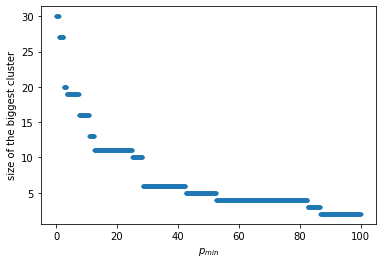

In [11]:
hc_matrix = np.loadtxt("../report/files/pyff_hc.dat")
pyff.cluster_plotter(hc_matrix, '../report/imgs/pyff_hc_cluster.pdf')

### Hydrogen bonds
Computing the hydrogen bonds interaction network and plotting the resulting matrix.

The hb analysis is a bit trickier; to build the hb network, we need MDAnalysis: first of all, extract from the data_dict the topology and the trajectory, codified as 'top' and 'traj' as keys (look at the params given as input). 

In [12]:
u = mda.Universe(data_dict['top'], data_dict['traj'], in_memory=True) 

# Need to know the number of entry to initialise the matrix:
sel = u.select_atoms(analysis_dict['system'])  
residxs = np.unique(sel.resindices) # extract all the indices of residues
nres = len(residxs)

# Need to know the number of frames to run in parallel (apply the formula to obtain the stride, but inverse):
if analysis_dict['stop'] == None:
    nframes = (u.trajectory.n_frames - analysis_dict['start']) // analysis_dict['stride']
else:
    nframes = (analysis_dict['stop'] - analysis_dict['start']) // analysis_dict['stride']

Now, run HB analysis. This function returns as many csv files (containing the results of the hb analysis) as the number of cores used for the calculation. If only one core is given all the analysis will be run on a single core and only one csv file will be generated, if run on n cores n csv files will be generated (we will use only one, but maybe more are just faster).

**it uses TONS OF TIME, SO LET'S SEE IF WE CAN IMPLEMENT IT JUST IN A BETTER WAY**

In [13]:
# same for the SB and hydrophB, but in this case specify all the frames/res as input. The output will be a .csv file.
pf.HBondInteraction(data_dict['top'], data_dict['traj'], 
                 donor_sel=hb_dict['donors'], 
                 acceptor_sel=hb_dict['acceptors'], 
                 nframe=nframes, output_csv=hb_dict['tmp_csv'], ncores=hb_dict['ncores'])

Using 6
THe intervals are: [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100), (100, None)]
Pooling with 6 core(s)...
Initialising: ForkPoolWorker-5Initialising: ForkPoolWorker-2Initialising: ForkPoolWorker-1Initialising: ForkPoolWorker-3Initialising: ForkPoolWorker-4Initialising: ForkPoolWorker-6





ForkPoolWorker-4 doing from 60 to 80, every 1 frameForkPoolWorker-2 doing from 20 to 40, every 1 frameForkPoolWorker-1 doing from 0 to 20, every 1 frameForkPoolWorker-6 doing from 100 to None, every 1 frameForkPoolWorker-5 doing from 80 to 100, every 1 frameForkPoolWorker-3 doing from 40 to 60, every 1 frame







/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(group), dtype=np.bool)
/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/core/selection.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.z

Creating table: ForkPoolWorker-3


/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/lib/distances.py:715: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gridsearch = FastNS(max_cutoff, configuration, box=box)


Creating table: ForkPoolWorker-2


/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/lib/distances.py:715: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gridsearch = FastNS(max_cutoff, configuration, box=box)


Creating table: ForkPoolWorker-5


/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/lib/distances.py:715: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gridsearch = FastNS(max_cutoff, configuration, box=box)
/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/lib/distances.py:715: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` 

Creating table: ForkPoolWorker-4
Creating table: ForkPoolWorker-1
Creating table: ForkPoolWorker-6


If more than one core is used, the following command merges all the .csv files generated in the previous step:

In [14]:
merged_df = pf.MergingHBDataframe(hb_dict['tmp_csv'], nframe=nframes, ncores=hb_dict['ncores']) 

Using 6


Now, as done previously, build the matrix 

In [15]:
pf.HBMatrix(u=u, nres=nres, nframes=nframes, hb_df=merged_df, 
         stride=analysis_dict['stride'], hb_file=hb_dict['hb_file'])

In [16]:
hb_matrix = np.loadtxt(hb_dict['hb_file'])
sns.heatmap(hb_matrix, square=True)

<AxesSubplot:>

# PSN
Generating the final Interaction Network merging together the sb, hc and hb matrix generated in the previous steps. The threshold for filtering is the same used by the authors of Pyinteraph for the example analysis

In [17]:
macro_inn = pyff.macroINN_generator([hc_matrix, sb_matrix, hb_matrix], 20) # uses all the matrices generated before

final_network = pyff.network_generator(macro_inn, PDB)

print(final_network.nodes)

['ALA1', 'GLN2', 'HIS3', 'ILE4', 'THR5', 'PRO6', 'VAL7', 'SER8', 'GLU9', 'LYS10', 'LYS11', 'VAL12', 'ASP13', 'ASP14', 'LYS15', 'ILE16', 'THR17', 'LEU18', 'TYR19', 'LYS20', 'THR21', 'THR22', 'ALA23', 'THR24', 'SER25', 'ASP26', 'SER27', 'ASP28', 'LYS29', 'LEU30', 'LYS31', 'ILE32', 'SER33', 'GLN34', 'ILE35', 'LEU36', 'THR37', 'PHE38', 'ASN39', 'PHE40', 'ILE41', 'LYS42', 'ASP43', 'LYS44', 'SER45', 'TYR46', 'ASP47', 'LYS48', 'ASP49', 'THR50', 'LEU51', 'ILE52', 'LEU53', 'LYS54', 'ALA55', 'ALA56', 'GLY57', 'ASN58', 'ILE59', 'TYR60', 'SER61', 'GLY62', 'TYR63', 'THR64', 'LYS65', 'PRO66', 'ASN67', 'PRO68', 'LYS69', 'ASP70', 'THR71', 'ILE72', 'SER73', 'SER74', 'GLN75', 'PHE76', 'TYR77', 'TRP78', 'GLY79', 'SER80', 'LYS81', 'TYR82', 'ASN83', 'ILE84', 'SER85', 'ILE86', 'ASN87', 'SER88', 'ASP89', 'SER90', 'ASN91', 'ASP92', 'SER93', 'VAL94', 'ASN95', 'VAL96', 'VAL97', 'ASP98', 'TYR99', 'ALA100', 'PRO101', 'LYS102', 'ASN103', 'GLN104', 'ASN105', 'GLU106', 'GLU107', 'PHE108', 'GLN109', 'VAL110', 'GLN111

/home/nicholas/anaconda3/envs/pyfferaph/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


Now the purpose is to build some other relevant analyses. 


**Shortest paths:** this function prints to file all shortest paths in final_network connecting ARG3 and SER150. A score is assigned to each path; the score is computed summing the frequencies, calculated over all the paths connecting source and target, of each residue in the path;
all_shortest_path returns the communication robustness (cr) index for the pathway source-target (s-t) as:

    cr(s-t) = (paths s-t) * treshold / lenght_shortest_path 

In [20]:
pyff.all_shortest_paths(final_network, ['ILE122'],  ['ILE277'], threshold=20)# --> example command

12 paths written to ILE122.dat


Suitable function for getting all shortest path and corrisponding cr index for each pair of residues in the two input lists. Convenient for studying connection of interfaces residues.